In [1]:
import requests #for requesting weather and ocean data
import pandas as pd
import datetime as dt
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xarray as xr
#import pygrib

Wave model parameters


1	245 	WIND 	m s**-1 	10 metre wind speed
2	249 	DWI  	degrees 	10 metre wind direction
3	229	SWH  	m 	Significant wave height
4	231 	PP1D 	s 	Dominant wave period / peak period of 1D spectra
5	232 	MWP  	s 	Mean wave period
6	221	MP2	s	Mean zero-crossing wave period
7	230 	MWD  	degrees 	

Mean wave direction
8	234	SHWW 	m 	Significant height of wind waves (sea)
9	236 	MPWW 	s 	Mean period of wind waves (sea)
10	235 	MDWW 	degrees 	Mean direction of wind waves (sea)
11	237	SHTS 	m 	Significant height of total swell
12	239	MPTS 	s 	Mean period of total swell
13	238	MDTS 	degrees 	Mean direction of total swell
14	253 	BFI  	- 	Benjamin-Feir index

In [2]:
api_key = '38d68b9b-c88f-4429-a5b6-0aa3cd565e7e' #API key from requesting DMI (Danish meterological institute) weather data
api_keyObs = '6eb4d132-2bc8-413c-a19a-310b447dbc07' #Api key for observed weather data
api_key_forecast = '3c6c7681-c254-4038-bbe4-3e1796357b7c' #API key for forecasting data DMI
api_key_edr = '5113209d-ee57-4070-a4a6-7fafd8cd858b' #API key for forecasting edr
api_key_ocean = '9e6aee57-e414-4ce9-9809-4183d6dda7d8' #API key for ocean data DMI
DMI_URL_ocean ='https://dmigw.govcloud.dk/v2/oceanObs/api/' #request link ocean without parameters
DMI_URL_only =' https://dmigw.govcloud.dk/v2/metObs/collections/observation/items' #request link without parameters
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/api'
DMI_Forecast = 'https://dmigw.govcloud.dk/v1/forecastedr/api' #request link for forecast
DMI_ForecastWAMDW = 'https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/items' #request link for wam in danish waters


In [4]:
stationIds = ['06079'] # Anholt weather station id
stationGrena = ['22121'] # Grenå sea level observation station

# Specify the desired start and end time
start_time = pd.Timestamp(2023, 9, 19)
end_time = pd.Timestamp(2023, 9, 21)
print('start time: '+ start_time.strftime('%d/%m/%Y, %H:%M') +'\nend time: ' + end_time.strftime('%d/%m/%Y, %H:%M'))

start time: 19/09/2023, 00:00
end time: 21/09/2023, 00:00


In [28]:
svartskarCube = '11.55,56.6,12,57.1'
kattegatPoints = [
    'POINT(11.2171 56.1639)',
    'POINT(11.6891 56.1577)',
    'POINT(12.3285 56.2067)',
    'POINT(12.1068 56.5170)',
    'POINT(11.6177 56.8219)',
    'POINT(12.0630 57.1064)']

molleCube = '11,56,12.5,56.75'

In [33]:



r1 = requests.get('https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/instances?api-key=5113209d-ee57-4070-a4a6-7fafd8cd858b')
json1 = r1.json()
instanceId = json1['instances'][2]['id']

r6 = requests.get(f'https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/instance/{instanceId}/cube?crs=crs84&f=GeoJSON',params={'api-key':api_key_edr,'bbox':svartskarCube})
r7 = requests.get(f'https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/instance/{instanceId}/position?crs=crs84&f=GeoJSON',params={'api-key':api_key_edr,'coords':'POINT(11.7169 55.71354)'})

json = r.json()
json6 = r6.json()

json7 = r7.json()
print(r)
#print(json)
print(r7)
#print(json.keys())
print(json1)

<Response [200]>
<Response [200]>
{'instances': [{'id': '2024-02-04T120000Z', 'title': 'The wam_dw model', 'description': 'Get WAM model forecast data from the area "Danish Waters"'}, {'id': '2024-02-04T060000Z', 'title': 'The wam_dw model', 'description': 'Get WAM model forecast data from the area "Danish Waters"'}, {'id': '2024-02-04T000000Z', 'title': 'The wam_dw model', 'description': 'Get WAM model forecast data from the area "Danish Waters"'}]}


In [47]:
dfs = []
for points in kattegatPoints:
    parameters = {'api-key':api_key_edr,'coords':points}
    r = requests.get(f'https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/instance/{instanceId}/position?crs=crs84&f=GeoJSON',params=parameters)
    json = r.json()
    dfi = pd.json_normalize(json['features'])
    dfs.append(dfi)
df = pd.concat(dfs, axis='columns').sort_index()

In [ ]:
df.keys()

In [9]:
r = requests.get('https://api.met.no/weatherapi/locationforecast/2.0/compact?lat=60.10&lon=9.58')
print(r)

<Response [403]>


In [7]:


# Specify one or more parameter IDs or all_parameters
parameterIds = ['wind_dir', 'wind_speed','wind_dir_past1h','wind_speed_past1h','wind_max','wind_max_per10min_past1h','pressure_at_sea']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
#datetime_str = start_time.tz_localize(None).isoformat() + '/' + end_time.tz_localize(None).isoformat()

#Setting up the data in a pandas dataframe. Instructions from DMI website: 
dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_keyObs,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '1000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL_only, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        #print(r)
        # Convert JSON object to a MultiIndex Pandas DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        #print(dfi.keys())
        if dfi.empty is False:
            #dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            dfi['time'] = dfi['properties.observed'] #Setting time index, without datetime format, since not supported by excel export
            dfi[['station', 'parameter']] = station, parameter
            
            dfi = dfi.set_index(['parameter', 'station', 'time'])
            
            dfi = dfi['properties.value'].unstack(['station','parameter'])
           
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()
#df = df.reset_index()

df.head()
df.tail()

station                 06079                                               \
parameter            wind_dir wind_speed wind_dir_past1h wind_speed_past1h   
time                                                                         
2023-09-20T23:20:00Z    176.0        9.4             NaN               NaN   
2023-09-20T23:30:00Z    175.0        9.7             NaN               NaN   
2023-09-20T23:40:00Z    172.0        9.2             NaN               NaN   
2023-09-20T23:50:00Z    175.0        9.2             NaN               NaN   
2023-09-21T00:00:00Z    177.0        9.0           176.0               9.3   

station                                                                 
parameter            wind_max wind_max_per10min_past1h pressure_at_sea  
time                                                                    
2023-09-20T23:20:00Z     11.9                      NaN          1002.2  
2023-09-20T23:30:00Z     11.3                      NaN          1002.1  
2023-09-20T23:40:00Z     11.0                      NaN          1002.0  
2023-09-20T23:50:00Z     11.0                      NaN          1001.8  
2023-09-21T00:00:00Z     10.8                      9.8          1001.7

In [3]:
#Wave model parameters
parameterIdsWave = ['mean-windwave-period']
start_time = pd.Timestamp(2023, 12, 19)
end_time = pd.Timestamp(2023, 12, 21)

In [8]:


# Specify one or more parameter IDs or all_parameters
#parameterIds = ['wind_dir', 'wind_speed','wind_dir_past1h','wind_speed_past1h','wind_max','wind_max_per10min_past1h','pressure_at_sea']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
#datetime_str = start_time.tz_localize(None).isoformat() + '/' + end_time.tz_localize(None).isoformat()

#Setting up the data in a pandas dataframe. Instructions from DMI website: 
dfs = []
#for station in stationIdsWave:
for parameter in parameterIdsWave:
        # Specify query parameters
    params = {
            'api-key' : api_key_forecast,
            'datetime' : datetime_str,
            'parameterId' : parameter,
            'limit' : '1000',  # max limit
        }

        # Submit GET request with url and parameters
    r = requests.get(DMI_ForecastWAMDW, params=params)
        # Extract JSON object
    json = r.json() # Extract JSON object
    print(r)
        # Convert JSON object to a MultiIndex Pandas DataFrame and add to list
    dfi = pd.json_normalize(json['features'])
        #print(dfi.keys())
    if dfi.empty is False:
            #dfi['time'] = pd.to_datetime(dfi['properties.observed'])
        dfi['time'] = dfi['properties.observed'] #Setting time index, without datetime format, since not supported by excel export
        dfi[['station', 'parameter']] = station, parameter
            
        dfi = dfi.set_index(['parameter', 'station', 'time'])
            
        dfi = dfi['properties.value'].unstack(['station','parameter'])
           
        dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()
#df = df.reset_index()

df.head()
df.tail()

<Response [403]>


KeyError: 'features'

In [192]:
df.to_excel('WindInfo.xlsx')

In [299]:
quality_data = pd.read_excel('WaveQuality_2023091920.xlsx') 
# Read the user wave quality data, with the same time index as the other dataframes

df['Quality']=quality_data['Quality']
df.head()


station                    time    06079                             \
parameter                       wind_dir wind_speed wind_dir_past1h   
0          2023-09-19T00:00:00Z    166.0        5.6           172.0   
1          2023-09-19T00:10:00Z    166.0        5.5             NaN   
2          2023-09-19T00:20:00Z    168.0        7.1             NaN   
3          2023-09-19T00:30:00Z    174.0        9.1             NaN   
4          2023-09-19T00:40:00Z    174.0        9.5             NaN   

station                                                                        \
parameter wind_speed_past1h wind_max wind_max_per10min_past1h pressure_at_sea   
0                       7.2      8.4                      8.6           997.3   
1                       NaN      8.1                      NaN           997.1   
2                       NaN      9.7                      NaN           996.9   
3                       NaN     11.6                      NaN           996.9   
4                       NaN     11.2                      NaN           996.7   

station   Quality  
parameter          
0               0  
1               0  
2               0  
3               0  
4               0

In [301]:
df_hourly = df.fillna(method='ffill')
df_hourly = df_hourly.drop(('06079','wind_max_per10min_past1h'),axis=1)

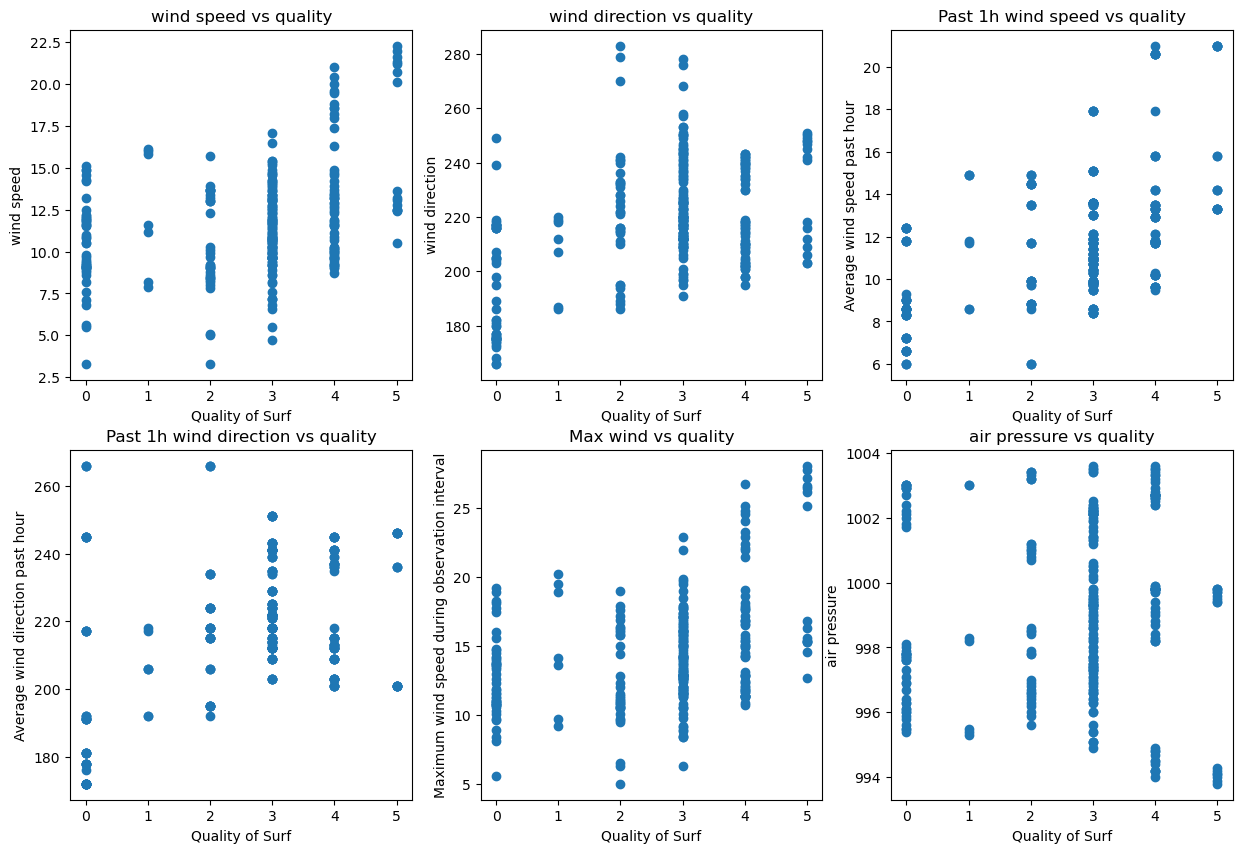

In [302]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0][0].scatter(df_hourly['Quality'],df_hourly['06079']['wind_speed']);
axes[0][0].set_xlabel("Quality of Surf")
axes[0][0].set_ylabel("wind speed")
axes[0][0].set_title("wind speed vs quality")

axes[0][1].scatter(df_hourly['Quality'],df_hourly['06079']['wind_dir']);
axes[0][1].set_xlabel("Quality of Surf")
axes[0][1].set_ylabel("wind direction")
axes[0][1].set_title("wind direction vs quality")

axes[0][2].scatter(df_hourly['Quality'],df_hourly['06079']['wind_speed_past1h']);
axes[0][2].set_xlabel("Quality of Surf")
axes[0][2].set_ylabel("Average wind speed past hour")
axes[0][2].set_title("Past 1h wind speed vs quality")

axes[1][0].scatter(df_hourly['Quality'],df_hourly['06079']['wind_dir_past1h']);
axes[1][0].set_xlabel("Quality of Surf")
axes[1][0].set_ylabel("Average wind direction past hour")
axes[1][0].set_title("Past 1h wind direction vs quality")

axes[1][1].scatter(df_hourly['Quality'],df_hourly['06079']['wind_max']);
axes[1][1].set_xlabel("Quality of Surf")
axes[1][1].set_ylabel("Maximum wind speed during observation interval")
axes[1][1].set_title("Max wind vs quality")

axes[1][2].scatter(df_hourly['Quality'],df_hourly['06079']['pressure_at_sea']);
axes[1][2].set_xlabel("Quality of Surf")
axes[1][2].set_ylabel("air pressure")
axes[1][2].set_title("air pressure vs quality")
plt.show()

(array([ 48.,   7.,  35., 123.,  76.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

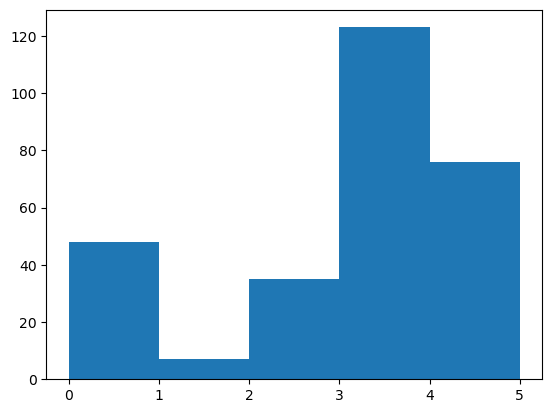

In [303]:
plt.hist(df_hourly['Quality'],bins=5)

In [304]:
# The dataset is divided into feature matrix X and label vector y for the model
X = df_hourly['06079'].to_numpy()
y = df_hourly['Quality'].to_numpy()
print(X.shape)
print(y.shape)

(289, 6)
(289,)


In [305]:
#Splitting the data into training and validation
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [306]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 12  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_12 = []          
mlp_val_errors_12 = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    
    mlp_tr_errors_12.append(tr_error)
    mlp_val_errors_12.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_12)
print(mlp_val_errors_12)

[153.51782477882116, 67.81686897074044, 1.7431735452910249, 4.91273417411904, 1.908115809806218, 1.8374756642290302]
[150.21247901287717, 74.80813017325012, 1.5259856930656241, 5.993521547067771, 2.4097493918843993, 2.2932340827636235]


In [307]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix


## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 15  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_15_neurons = []          
mlp_val_errors_15_neurons = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    mlp_tr_errors_15_neurons.append(tr_error)
    mlp_val_errors_15_neurons.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_15_neurons)
print(mlp_val_errors_15_neurons)

[28.591876425725363, 8.319368476544582, 1.8230250516152942, 1.543102534363161, 2.065067198598235, 2.0247098973603097]
[30.5703058509921, 9.080440530138024, 2.856044918632759, 1.8811563472302077, 2.0599654208237297, 2.625447367560321]


In [308]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 20  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_20_neurons = []          
mlp_val_errors_20_neurons = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    
    mlp_tr_errors_20_neurons.append(tr_error)
    mlp_val_errors_20_neurons.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_20_neurons)
print(mlp_val_errors_20_neurons)

[25.510366924949373, 109.27997974323188, 2.0473428095859125, 1.453902740087285, 2.0368081986727393, 1.9535937782597863]
[29.038250055947028, 108.52004957781267, 2.0854452526679594, 1.822689551982202, 2.5900667737462912, 2.455394615604649]


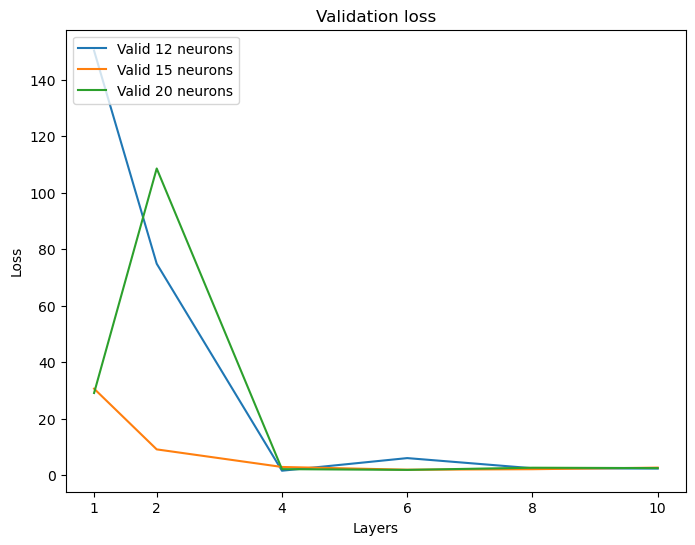

In [309]:
plt.figure(figsize=(8, 6))

plt.plot(num_layers, mlp_val_errors_12, label = 'Valid 12 neurons')
plt.plot(num_layers, mlp_val_errors_15_neurons,label = 'Valid 15 neurons')
plt.plot(num_layers, mlp_val_errors_20_neurons,label = 'Valid 20 neurons')
plt.xticks(num_layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.show()


In [310]:
errors = {"num_hidden_layers":num_layers,
          "mlp_val_errors_12N":mlp_val_errors_12,
          "mlp_val_errors_15N":mlp_val_errors_15_neurons,
          "mlp_val_errors_20N":mlp_val_errors_20_neurons
         }
errors_df = pd.DataFrame(errors)
errors_df

,num_hidden_layers,mlp_val_errors_12N,mlp_val_errors_15N,mlp_val_errors_20N
0,1,150.212479,30.570306,29.038250
1,2,74.808130,9.080441,108.520050
2,4,1.525986,2.856045,2.085445
3,6,5.993522,1.881156,1.822690
4,8,2.409749,2.059965,2.590067
5,10,2.293234,2.625447,2.455395


In [293]:
errors_df.to_excel('errors.xlsx')